# LioJotstar Merger: Data Analysis with Python for Strategic Optimization

## 8. Upgrade Patterns: Who’s Moving Up and Why?
This notebook delves into the upgrade patterns of LioCinema and Jotstar subscribers. It visualizes monthly upgrade trends, the age and city tier demographics of users who upgraded, and the specific 'from' and 'to' plan transitions using combinations of grouped bar and line charts, population pyramids, stacked bar charts, and pie charts to understand who is upgrading and when.

### Importing Required Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Required DataFrames from Saved Parquet Files

In [6]:
try:
    jotstar_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/Jotstar_db/subscribers.parquet')
    print("Jotstar - Subscribers table loaded successfully.")
    liocinema_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/LioCinema_db/subscribers.parquet')
    print("LioCinema - Subscribers table loaded successfully.")
    print("\nData Loading Complete.")
    
except FileNotFoundError as e:
       print("Error: One or more Parquet files not found. Please check the file paths.")
       print(f"Details: {e}")
except Exception as e:
       print("An error occurred during data import.")
       print(f"Details: {e}")

Jotstar - Subscribers table loaded successfully.
LioCinema - Subscribers table loaded successfully.

Data Loading Complete.


### Data Analysis & Visualization

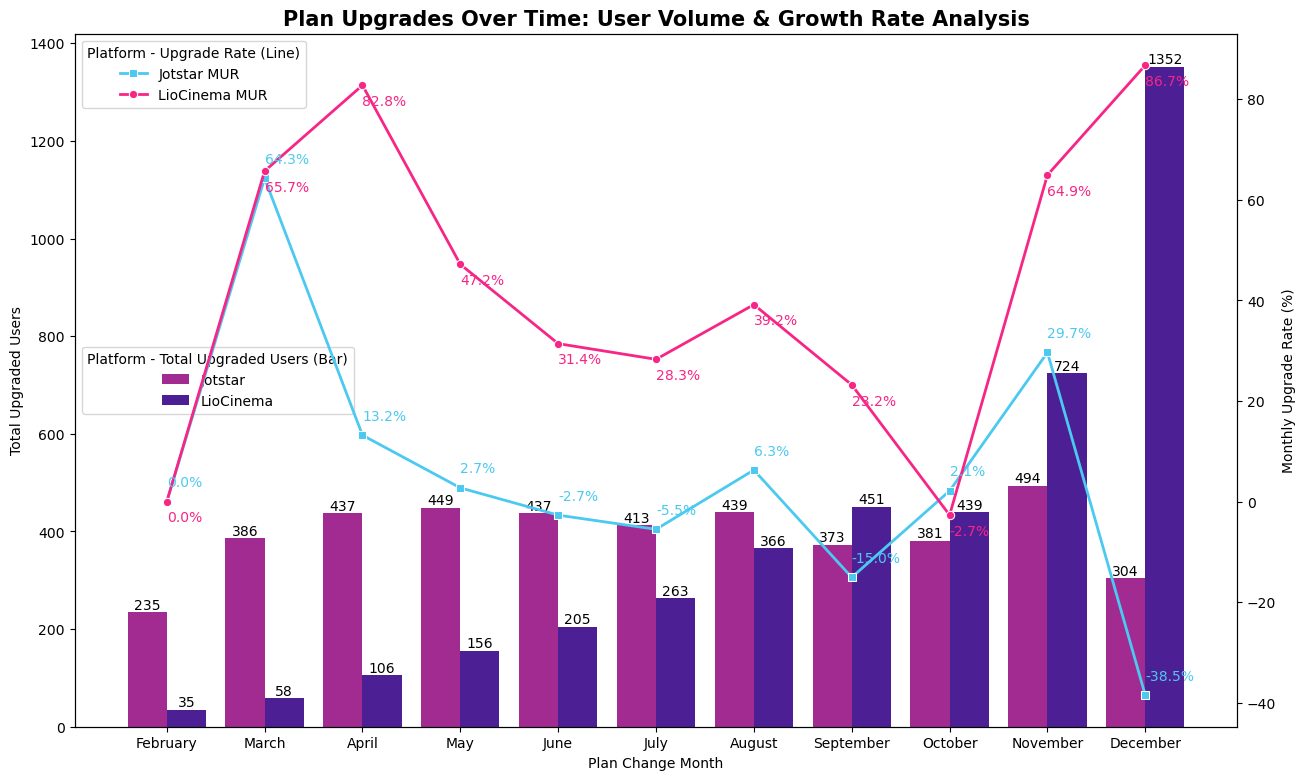

In [8]:
def get_upgraded_user_count(df):
    temp_df = df[['User ID', 'Plan Change Date', 'Plan Change Type']].copy()
    temp_df['Plan Change Month Number'] = temp_df['Plan Change Date'].dt.month
    temp_df['Plan Change Month'] = temp_df['Plan Change Date'].dt.month_name()
    result = temp_df.groupby(['Plan Change Month Number', 'Plan Change Month', 'Plan Change Type'])['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID': 'Total Upgraded Users'})
    # Calculate Monthly Upgrade Rate
    result['Monthly Upgrade Rate (%)'] = result['Total Upgraded Users'].pct_change() * 100
    result['Monthly Upgrade Rate (%)'] = result['Monthly Upgrade Rate (%)'].fillna(0)
    return result
    
jotstar_temp_df = get_upgraded_user_count(jotstar_subscribers_df[jotstar_subscribers_df['Plan Change Type'] == "Upgrade"])
liocinema_temp_df = get_upgraded_user_count(liocinema_subscribers_df[liocinema_subscribers_df['Plan Change Type'] == "Upgrade"])
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])
merged_df = merged_df.reset_index()
merged_df = merged_df.sort_index()

fig, ax1 = plt.subplots(figsize = (15, 9))
ax2 = ax1.twinx()

bp = sns.barplot(x = 'Plan Change Month', y = 'Total Upgraded Users', data = merged_df, hue = 'Platform', palette = ["#B5179E", "#480CA8"], 
                 ax = ax1)
for i in bp.containers:
    bp.bar_label(i)

sns.lineplot(x = 'Plan Change Month', y = 'Monthly Upgrade Rate (%)', data = merged_df[merged_df['Platform'] == "Jotstar"], 
             color = "#4CC9F0", marker = "s", linewidth = 2, ax = ax2, label = "Jotstar MUR")
for a, b, platform in zip(merged_df['Plan Change Month'], merged_df['Monthly Upgrade Rate (%)'], merged_df['Platform']):
    if platform == "Jotstar": 
        plt.text(x = a, y = b + 3, s = f"{b:.1f}%", color = "#4CC9F0")

sns.lineplot(x = 'Plan Change Month', y = 'Monthly Upgrade Rate (%)', data = merged_df[merged_df['Platform'] == "LioCinema"], 
             color = "#F72585", marker = "o", linewidth = 2, ax = ax2, label = "LioCinema MUR")
for a, b, platform in zip(merged_df['Plan Change Month'], merged_df['Monthly Upgrade Rate (%)'], merged_df['Platform']):
    if platform == "LioCinema": 
        plt.text(x = a, y = b - 4, s = f"{b:.1f}%", color = "#F72585")

plt.title("Plan Upgrades Over Time: User Volume & Growth Rate Analysis", fontsize = 15, fontweight = "bold")
ax1.grid(False)
ax2.grid(False)
ax1.legend(title = "Platform - Total Upgraded Users (Bar)", loc = "center left")
ax2.legend(title = "Platform - Upgrade Rate (Line)", loc = "upper left")

# Saving multi-row KPI to Excel for Tabular viewing
merged_df.to_excel('KPIs Excel Files/Monthly Upgrade Rate.xlsx')

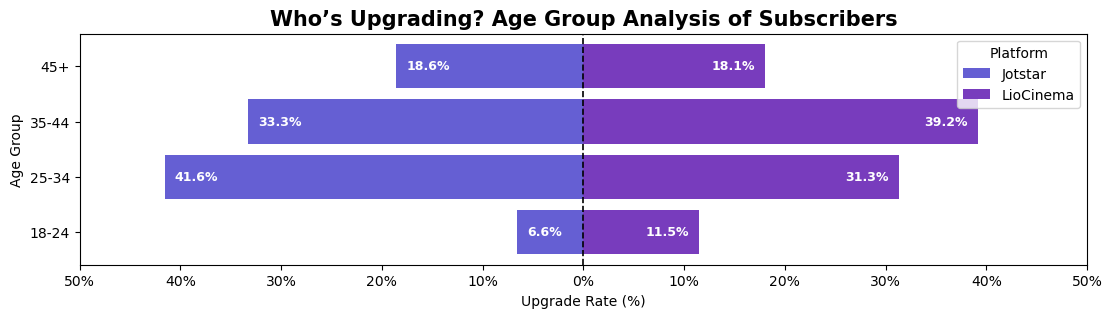

In [9]:
def get_upgraded_user_count(df):
    result = df.groupby('Age Group')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Upgraded Users'}).reset_index()
    total_upgraded_users = sum(result['Total Upgraded Users'])
    result['Upgrade Rate (%)'] = ((result['Total Upgraded Users'] / total_upgraded_users) * 100).round(2)
    return result
    
jotstar_temp_df = get_upgraded_user_count(jotstar_subscribers_df[jotstar_subscribers_df['Plan Change Type'] == "Upgrade"])
jotstar_temp_df['Upgrade Rate (%)'] *= -1
liocinema_temp_df = get_upgraded_user_count(liocinema_subscribers_df[liocinema_subscribers_df['Plan Change Type'] == "Upgrade"])

plt.subplots(figsize = (13, 3))
plt.title("Who’s Upgrading? Age Group Analysis of Subscribers", fontsize = 15, fontweight = "bold")

bars_js = plt.barh(jotstar_temp_df['Age Group'], jotstar_temp_df['Upgrade Rate (%)'], color = "#3F37C9", label = "Jotstar", alpha = 0.8)

bars_lc = plt.barh(liocinema_temp_df['Age Group'], liocinema_temp_df['Upgrade Rate (%)'], color = "#560BAD", label = "LioCinema", alpha = 0.8)

for bar in bars_js:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f"{abs(bar.get_width()):.1f}%", 
             va = "center", ha = "left", color = "white", fontsize = 9, fontweight = "bold")

for bar in bars_lc:
    plt.text(bar.get_width() - 1, bar.get_y() + bar.get_height()/2,  
             f"{bar.get_width():.1f}%",  
             va = "center", ha = "right", color = "white", fontsize = 9, fontweight = "bold")

plt.xlabel("Upgrade Rate (%)")
plt.ylabel("Age Group")
plt.axvline(0, color = "black", linewidth = 1.2, linestyle = "dashed")
plt.xticks(ticks = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], 
           labels = ['50%', '40%', '30%', '20%', '10%', '0%', '10%', '20%', '30%', '40%', '50%'])
plt.legend(title = "Platform", loc = "upper right")

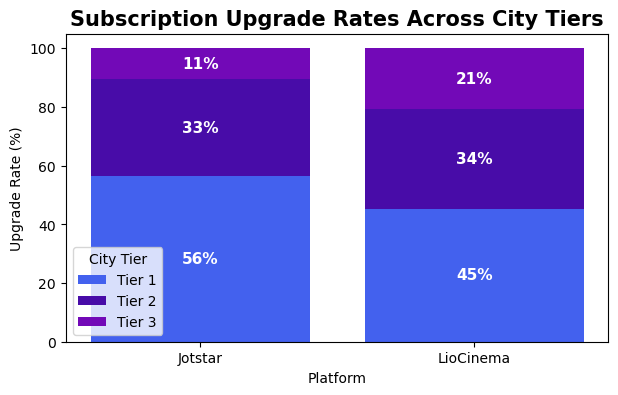

In [10]:
def get_upgraded_user_count(df):
    result = df.groupby('City Tier')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Upgraded Users'}).reset_index()
    total_upgraded_users = sum(result['Total Upgraded Users'])
    result['Upgrade Rate (%)'] = ((result['Total Upgraded Users'] / total_upgraded_users) * 100)
    return result
    
jotstar_temp_df = get_upgraded_user_count(jotstar_subscribers_df[jotstar_subscribers_df['Plan Change Type'] == "Upgrade"])
liocinema_temp_df = get_upgraded_user_count(liocinema_subscribers_df[liocinema_subscribers_df['Plan Change Type'] == "Upgrade"])
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])

pivot_df = merged_df.pivot(index = 'Platform', columns = 'City Tier', values = ['Upgrade Rate (%)']).fillna(0)

total_upgrade_rate = pivot_df['Upgrade Rate (%)']

fig, ax = plt.subplots(figsize = (7, 4))

bars_tier1 = ax.bar(total_upgrade_rate.index, total_upgrade_rate.get("Tier 1", 0), color = "#4361EE", label = "Tier 1")

bars_tier2 = ax.bar(total_upgrade_rate.index, total_upgrade_rate.get("Tier 2", 0), 
                 bottom = total_upgrade_rate.get("Tier 1", 0), color = "#480CA8", 
                    label = "Tier 2")

bars_tier3 = ax.bar(total_upgrade_rate.index, total_upgrade_rate.get("Tier 3", 0), 
                   bottom = total_upgrade_rate.get("Tier 1", 0) + total_upgrade_rate.get("Tier 2", 0), 
                   color = "#7209B7", label = "Tier 3")

for bars in [bars_tier1, bars_tier2, bars_tier3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,  
                    f"{height:.0f}%",  
                    ha = "center", va = "center", color = "white", fontsize = 11, fontweight = "bold")

ax.set_xlabel("Platform")
ax.set_ylabel("Upgrade Rate (%)")
ax.set_title("Subscription Upgrade Rates Across City Tiers", fontsize = 15 , fontweight = "bold")
ax.legend(title = "City Tier", loc = "best")

([<matplotlib.patches.Wedge at 0x20ef86a5520>,
 [Text(-0.0004158713196601715, 1.099999921386836, 'Free → Basic'),
  Text(-0.5657693516600417, -0.9433477835465435, 'Basic → Premium'),
  Text(0.9431338186315867, -0.5661259578516086, 'Free → Premium')],
 [Text(-0.0002268389016328208, 0.5999999571200924, '50.0%'),
  Text(-0.3086014645418409, -0.5145533364799327, '32.8%'),
  Text(0.5144366283445018, -0.30879597700996825, '17.2%')])

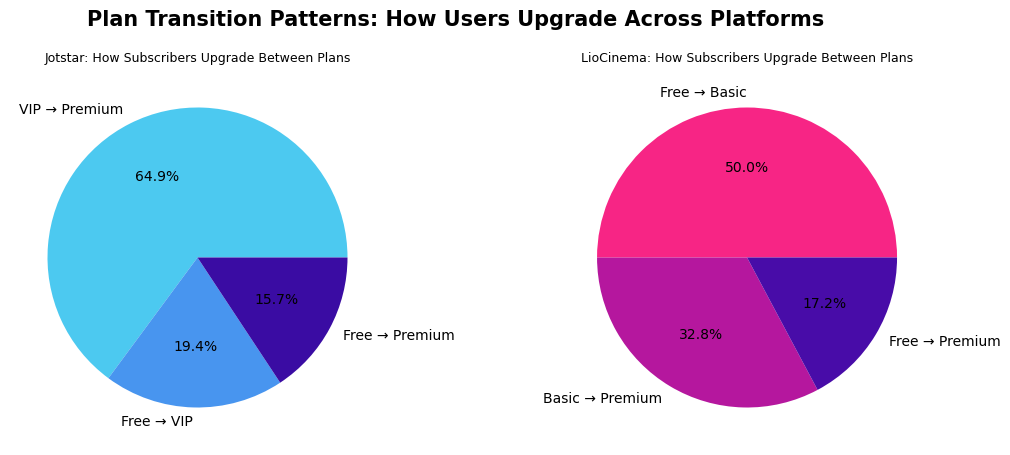

In [11]:
def get_upgraded_user_count(df):
    result = df.groupby('Plan Transition')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Upgraded Users'}).reset_index()
    result = result.sort_values('Total Upgraded Users', ascending = False)
    return result
    
jotstar_temp_df = get_upgraded_user_count(jotstar_subscribers_df[jotstar_subscribers_df['Plan Change Type'] == "Upgrade"])
liocinema_temp_df = get_upgraded_user_count(liocinema_subscribers_df[liocinema_subscribers_df['Plan Change Type'] == "Upgrade"])

plt.figure(figsize = (13, 5))
plt.subplots_adjust(top = 0.86)
plt.suptitle("Plan Transition Patterns: How Users Upgrade Across Platforms", fontsize = 15, fontweight = "bold")

Jotstar = ["#4CC9F0", "#4895EF", "#3A0CA3"]
LioCinema = ["#F72585", "#B5179E", "#480CA8"]

ax1 = plt.subplot(1, 2, 1)
ax1.set_aspect("equal")
plt.title("Jotstar: How Subscribers Upgrade Between Plans", fontsize = 9)
plt.pie(jotstar_temp_df['Total Upgraded Users'], labels = jotstar_temp_df['Plan Transition'], autopct='%1.1f%%', colors = Jotstar)

ax2 = plt.subplot(1, 2, 2)
ax2.set_aspect("equal")
plt.title("LioCinema: How Subscribers Upgrade Between Plans", fontsize = 9)
plt.pie(liocinema_temp_df['Total Upgraded Users'], labels = liocinema_temp_df['Plan Transition'], autopct='%1.1f%%', colors = LioCinema)

## Next Notebook: "9. The Downgrade Shift: Analyzing User Transitions"